# 1. Libraries

In [1]:
%conda install -c conda-forge scikit-multiflow

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda




In [2]:
import numpy as np
import pandas as pd

#https://scikit-multiflow.github.io/scikit-multiflow/documentation.html#learning-methods
from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection.eddm import EDDM
from skmultiflow.drift_detection import PageHinkley
from skmultiflow.drift_detection.adwin import ADWIN

from skmultiflow.meta import AdaptiveRandomForest
from skmultiflow.evaluation import EvaluatePrequential

from skmultiflow.data import DataStream

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import glob

# 2. Dataset

In [5]:
base_path = "#datasets"
dataset_scaled = pd.read_csv(f'{base_path}/Tennessee_Event-Driven/datasets/dataset_standard_scaled.csv',index_col=False)

# 3. Stream Machine Learning

In [9]:
samples = dataset_scaled[dataset_scaled.columns[:-1]]
labels = dataset_scaled[dataset_scaled.columns[-1]].to_frame()

stream = DataStream(data = samples, y = labels)
stream.prepare_for_use()

ARF = AdaptiveRandomForest()

evaluator = EvaluatePrequential(n_wait=200, pretrain_size=200, output_file=f"{base_path}/Tennessee_Event-Driven/results/py_ARF_results.csv")
# Run evaluation
evaluator.evaluate(stream=stream, model=ARF, model_names=['ARF'])

C:\ProgramData\Anaconda3\envs\FIREMAN-project\lib\site-packages\skmultiflow\data\base_stream.py:191: FutureWarning: 'prepare_for_use' has been deprecated in v0.5.0 and will be removed in v0.7.0.
New instances of the Stream class are now ready to use after instantiation.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\FIREMAN-project\lib\site-packages\skmultiflow\meta\adaptive_random_forests.py:39: FutureWarning: ’AdaptiveRandomForest’ has been renamed to ‘AdaptiveRandomForestClassifier’ in v0.5.0.
The old name will be removed in v0.7.0
  warnings.warn("’AdaptiveRandomForest’ has been renamed to ‘AdaptiveRandomForestClassifier’ "


Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [224.63s]
Processed samples: 31700
Mean performance:
ARF - Accuracy     : 0.9907
ARF - Kappa        : 0.9903


[AdaptiveRandomForestClassifier(binary_split=False, disable_weighted_vote=False,
                                drift_detection_method=ADWIN(delta=0.001),
                                grace_period=50, lambda_value=6,
                                leaf_prediction='nba', max_byte_size=33554432,
                                max_features=7, memory_estimate_period=2000000,
                                n_estimators=10, nb_threshold=0,
                                no_preprune=False, nominal_attributes=None,
                                performance_metric='acc', random_state=None,
                                remove_poor_atts=False, split_confidence=0.01,
                                split_criterion='info_gain',
                                stop_mem_management=False, tie_threshold=0.05,
                                warning_detection_method=ADWIN(delta=0.01))]

In [11]:
# skmultiflow saves results to file with leading 5 lines containing configuraiton of evaluation, learner etc
# skmultiflow also did not evaluate last 200 samples
# for the sake of comparisson we shrink the MOA results
# accuracy in MOA is in % and in skmultiflow fraction
py_ARF_results = pd.read_csv(f'{base_path}/Tennessee_Event-Driven/results/py_ARF_results.csv',skiprows=[0,1,2,3,4],index_col=False)
py_ARF_results['mean_acc_[ARF]'] = py_ARF_results['mean_acc_[ARF]']*100
# moa_ARF_results = pd.read_csv('Tennessee_Event-Driven/results/moa_ARF_results.csv',index_col=False)
# moa_ARF_results = moa_ARF_results.iloc[:-1]

In [12]:
py_ARF_results.head()

,id,mean_acc_[ARF],current_acc_[ARF],mean_kappa_[ARF],current_kappa_[ARF]
0,200,100.0,1.0,0.0,0.0
1,399,100.0,1.0,0.0,0.0
2,599,100.0,1.0,0.0,0.0
3,799,100.0,1.0,0.0,0.0
4,999,100.0,1.0,0.0,0.0


In [ ]:
# moa_ARF_results.head()

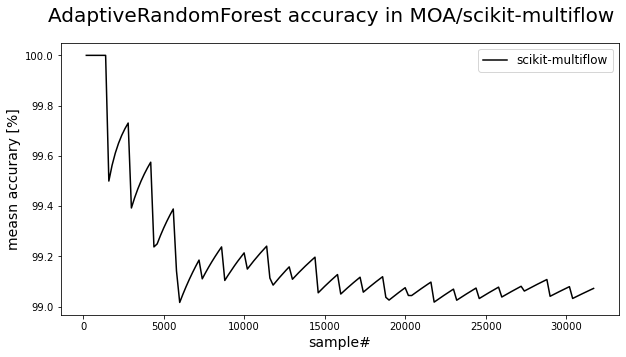

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle('AdaptiveRandomForest accuracy in MOA/scikit-multiflow', size=20)
# moa_ARF_results.plot(x='learning evaluation instances', y = '[avg] classifications correct (percent)',ax=ax,color='blue')
py_ARF_results.plot(x = 'id',y = 'mean_acc_[ARF]', ax=ax,color='black')
ax.set_xlabel('sample#',size=14)
ax.set_ylabel('measn accurary [%]',size=14)
ax.legend()

ax.legend(['scikit-multiflow'], fontsize=12);

# 4. Concept Drift Detection
I stole this picture from :

    "Gama, J., Žliobaitė, I., Bifet, A., Pechenizkiy, M., & Bouchachia, A. (2014). A survey on concept drift adaptation. ACM computing surveys (CSUR), 46(4), 1-37."
    
I think it nicely shows categoies of concept drifts.
![missing_image](images/Pattern_of_change_over_time_(outlier_is_not_concept_drift).png "Pattern of change over time (outlier is not concept drift)")

In [ ]:
# check where the fault_id changes - i.e. the concept_drift should occur and mark that sample with "1" (initial sample has NA - fill with 0)
dataset_scaled['fault_id_change'] = dataset_scaled['fault_id'].diff().fillna(0)

In [ ]:
dataset_scaled[dataset_scaled['fault_id_change'] != 0].head()

In [ ]:
# magnitude of row vectors - concept drift detectors take as input single value not list/vector
dataset_scaled['magnitude'] = dataset_scaled[dataset_scaled.columns[:-1]].apply(np.linalg.norm, axis=1)
data_stream = dataset_scaled['magnitude'].values

In [ ]:
adwin = ADWIN()
ddm = DDM()
eddm = EDDM()
ph = PageHinkley()

# Adding stream elements to ADWIN and verifying if drift occurred
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    #ddm.add_element(data_stream[i])
    #eddm.add_element(data_stream[i])
    #ph.add_element(data_stream[i])
    if ph.detected_change():
        print('Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))